# QR Code Detection

The general construction of a QR code is demonstrated in the following image, borrowed from [QR Code Detection and Extraction](http://dsynflo.blogspot.de/2014/10/opencv-qr-code-detection-and-extraction.html).
In the most general case, the code contains three positional markers, consisting of a black frame with a thickness of one unit, a white frame of one unit and a final enclosed black square of three units edge length.
When scanning the image pixelwise in either direction, this results in a `1-1-3-1-1` unit intensity pattern. When looking at the contours, the areas are `7x7-5x5-3x3` units.

![](./doc/qr-code-parts.png)

Additional QR code variants can be found [here](http://qrcode.meetheed.com/qrcode_examples.php).

### Anaconda note

If you run Anaconda and Jupyter is not recognizing your environment, run 

```bash
conda install nb_conda
```

After restarting Jupyter you can then select the kernel matching your conda env.

## General imports

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from os import path

## Code extraction

Let's quickly load and display an image containing a QR code:

In [2]:
def read_image(name: str) -> np.ndarray:
    return cv2.imread(path.join('images', name), cv2.IMREAD_GRAYSCALE) / 255.

img = read_image('qr3.png')

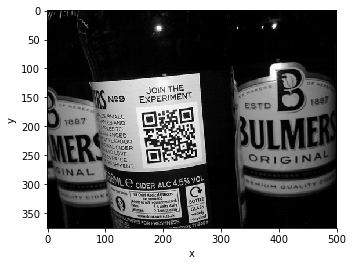

In [3]:
def plot(img: np.ndarray, title: str, xlabel: str='x', ylabel: str='y'):
    plt.figure(title)
    plt.imshow(img, cmap='gray')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot(img, 'Original (grayscale)')

Let's now take a look at the edges by obtaining an Laplacian-of-Gaussian filter.

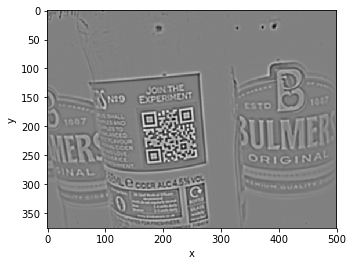

In [4]:
blur_kernel_size = (5, 5)
blurred = img
for i in range(3):
    blurred = cv2.GaussianBlur(blurred, blur_kernel_size, 0)

edges = cv2.Laplacian(blurred, cv2.CV_64F)
plot(edges, 'Edges (LoG)')

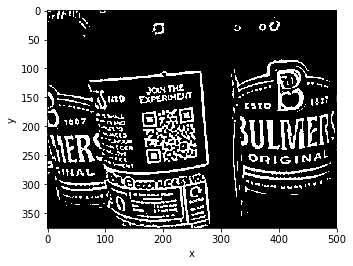

In [5]:
val, img_t = cv2.threshold(edges, thresh=.01, maxval=1., type=cv2.THRESH_BINARY)
plot(img_t, 'Thresholded edges')

We could apply a morphological closing operation to find big blobs of continous pixels, resulting in areas of interest to look at. Here, for example, the QR code itself results in a big blob. However, since QR codes are also allowed to be "empty", this idea might not work as expected.

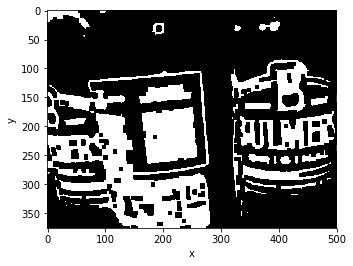

In [6]:
kernel = np.ones((7, 7), np.float32)
img_closed = cv2.morphologyEx(img_t, cv2.MORPH_CLOSE, kernel)
plot(img_closed, 'Closed edges')

In order discard small blobs, we need to evaluate them. OpenCV can do that for us already, so we simply run contour detection instead.
Here, `cv2.CHAIN_APPROX_SIMPLE` is used as an optimization: Since we are generally only interested in almost-linear shapes (i.e. the edges of the QR code), we simply store the edges of the contour rather than all border pixels.
We used `cv2.RETR_TREE` to also obtain the hierarchy of the contours: This way we can detect QR code marker candidates from the relation of their contour sizes.

In [7]:
img_tb = img_t.astype(np.uint8)
im2, contours, hierarchy = cv2.findContours(img_tb, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

assert hierarchy.shape[0] == 1
hierarchy = hierarchy[0]

The `hierarchy` list encodes relations of the found contours. The individual components are:

1. Next contour ID in the same hierarchy level
2. Previous contour ID in the same hierarchy level
3. First child contour ID
4. Parent contour ID

In [8]:
print(hierarchy)

[[  1  -1  -1  -1]
 [  2   0  -1  -1]
 [  3   1  -1  -1]
 ..., 
 [318 316  -1  -1]
 [319 317  -1  -1]
 [ -1 318  -1  -1]]


By definition of our problem we can drop all contours that neither have a parent, nor childs (i.e. end in `-1, -1`).

In [9]:
def filter_contours(cs, hs):
    has_childs = hierarchy[:, 2] >= 0
    has_parents = hierarchy[:, 3] >= 0
    cs, h = zip(*[(c, h) for i, (c, h) 
                  in enumerate(zip(contours, hierarchy)) 
                  if has_childs[i] or has_parents[i]])
    return cs, np.array(h)
    
filtered_contours, filtered_hierarchy = filter_contours(contours, hierarchy)
print(f'Contours: {len(filtered_contours)}, hierarchy tree: {filtered_hierarchy.shape}')

Contours: 70, hierarchy tree: (70, 4)


For validation purposes we convert the original `np.float32` grayscale image into an `np.uint8` RGB image:

In [10]:
img_u8 = (np.repeat(img[..., np.newaxis], 3, axis=2) * 255.).astype(np.uint8)

We can now draw the contours to see what OpenCV detected:

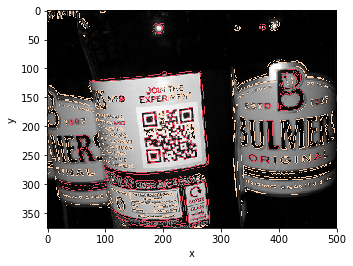

In [11]:
img_contours = img_u8.copy()
cv2.drawContours(img_contours, contours, -1, (254, 206, 168), 1)
cv2.drawContours(img_contours, filtered_contours, -1, (232, 74, 95), 1)
plot(img_contours, 'Filtered contours')

We now try to find contours that match the `7-5-3` area rule. Since we know the black square does (and must) not contain any other contours, we start at the lowest level contours with parents and work our way up.

Candidate 121 > 122 > 123:
  a5:a3 = 2.0418
  a7:a3 = 2.6280
  a7:a5 = 1.2871
  MSE   = 0.2402
Candidate 191 > 192 > 193:
  a5:a3 = 2.0754
  a7:a3 = 2.6628
  a7:a5 = 1.2830
  MSE   = 0.2892
Candidate 210 > 211 > 212:
  a5:a3 = 2.1058
  a7:a3 = 2.7181
  a7:a5 = 1.2908
  MSE   = 0.3527


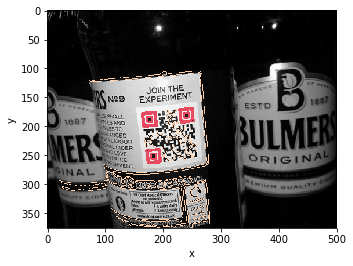

In [12]:
bottom_level_candidates = ((i, h) for (i, h) in enumerate(hierarchy) if h[2] == -1 and h[3] >= 0)

unchecked_candidates = []
checked_candidates = []

mse_threshold = 1.

for i, h in bottom_level_candidates:
    c3_idx, c5_idx = i, h[3]
    c7_idx = hierarchy[c5_idx, 3]
    if c7_idx == -1:
        continue

    c3 = contours[c3_idx]
    c5 = contours[c5_idx]
    c7 = contours[c7_idx]
    unchecked_candidates.extend([c3, c5, c7])
        
    a3 = np.sqrt(cv2.contourArea(contours[c3_idx]))
    a5 = np.sqrt(cv2.contourArea(contours[c5_idx]))
    a7 = np.sqrt(cv2.contourArea(contours[c7_idx]))
    
    a5_a3 = a5 / a3
    a7_a3 = a7 / a3
    a7_a5 = a7 / a5
        
    mse = (a5_a3 - 1.667)**2 + (a7_a3 - 2.333)**2 + (a7_a5 - 1.4)**2
    if mse < mse_threshold:
        checked_candidates.extend([c3, c5, c7])
        print(f'Candidate {c7_idx} > {c5_idx} > {c3_idx}:')
        print(f'  a5:a3 = {a5_a3:1.4f}\n'
              f'  a7:a3 = {a7_a3:1.4f}\n'
              f'  a7:a5 = {a7_a5:1.4f}\n'
              f'  MSE   = {mse:1.4f}')


img_contours = img_u8.copy()
cv2.drawContours(img_contours, unchecked_candidates, -1, (254, 206, 168), 1)
cv2.drawContours(img_contours, checked_candidates, -1, (232, 74, 95), 2)
plot(img_contours, 'Candidate contours')